# Model Training and Model Evaluation

## 1. Import Packages and Data Loading

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [21]:
X_train = pd.read_csv("X_train.csv")
X_val = pd.read_csv("X_val.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv")
y_val = pd.read_csv("y_val.csv")
y_test = pd.read_csv("y_test.csv")

## 2. Model Training

In [23]:
models = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(max_iter=1000),
        "param_grid": {
            "C": [0.05, 0.1, 1, 5, 10],  # more granularity
            "penalty": ['l2'],  
            "solver": ['lbfgs']
        }
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 75, 100],  # add 75
            "max_depth": [None, 8, 12],     # add 8 and 12
            "min_samples_split": [2, 4, 6], # add 4 and 6
            "max_features": ['sqrt', 'log2'] # add log2 option
        }
    },
    {
        "name": "GradientBoosting",
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 75, 100],
            "learning_rate": [0.01, 0.05, 0.1], # added 0.05
            "max_depth": [3, 4, 5]               # added 4
        }
    },
    {
        "name": "KNeighbors",
        "estimator": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 4, 5],   # added 4
            "weights": ['uniform', 'distance']  # added distance weighting
        }
    },
    {
        "name": "SVC",
        "estimator": SVC(),
        "param_grid": {
            "C": [1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ['scale', 'auto']
        }
    },
    {
        "name": "GaussianNB",
        "estimator": GaussianNB(),
        "param_grid": {}
    },
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [None, 8, 12],
            "min_samples_split": [2, 4, 6]
        }
    },
    {
        "name": "AdaBoost",
        "estimator": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 75, 100],
            "learning_rate": [0.01, 0.05, 0.1]
        }
    },
    {
        "name": "XGBoost",
        "estimator": XGBClassifier(eval_metric='mlogloss', random_state=42),
        "param_grid": {
            "n_estimators": [50, 75, 100],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 4, 5]
        }
    },
    {
		"name": "CatBoost",
        "estimator": CatBoostClassifier(verbose=False, random_state=42),
        "param_grid": {
        }
	}
]

In [24]:
# Store results
results = []

# Loop over each model
for m in models:
    print(f"Training {m['name']}...")
    grid = GridSearchCV(estimator=m["estimator"],
                        param_grid=m["param_grid"],
                        cv=5,
                        scoring="accuracy",
                        n_jobs=-1)
    grid.fit(X_train, y_train["ms"].ravel())
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    results.append({
        "Model": m["name"],
        "Best Params": grid.best_params_,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })

# Show results
results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False)
print(results_df.to_string(index=False))

Training LogisticRegression...
Training RandomForest...
Training GradientBoosting...
Training KNeighbors...
Training SVC...
Training GaussianNB...
Training DecisionTree...
Training AdaBoost...
Training XGBoost...
Training CatBoost...
             Model                                                                           Best Params  Validation Accuracy  Test Accuracy
          CatBoost                                                                                    {}             0.907614       0.907614
      RandomForest {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}             0.884873       0.884873
        KNeighbors                                              {'n_neighbors': 5, 'weights': 'uniform'}             0.879391       0.879391
      DecisionTree                                              {'max_depth': 8, 'min_samples_split': 2}             0.876954       0.876954
  GradientBoosting                           {'learning_rate'

In [34]:
best_model.feature_importances_

array([12.92768447, 14.57814286, 23.91886752, 13.05124377, 23.64923914,
       11.87482223])

In [36]:
best_model.feature_names_

['0', '1', '2', '3', '4', '5']

**Preprocessor Pipeline**

In [29]:
numeric_transformer = StandardScaler()
ordinal_encoder = OrdinalEncoder()

numerical_column = ["age", "num_brought_up_children"]
ordinal_column = ["religiosity", "safety", "love", "globe"]

preprocessor = ColumnTransformer(
	[
		("Ordinal_Encoder", ordinal_encoder, ordinal_column),
		("StandardScaler", numeric_transformer, numerical_column)
	]
)

In [30]:
sample_input = pd.DataFrame([{
    'age': 35,
    'num_brought_up_children': 2,
    'religiosity': 3,
    'safety': 4,
    'love': 3,
    'globe': 3
}])

preprocessor.fit(X_train[numerical_column + ordinal_column])
transformed_input = preprocessor.transform(sample_input)

prediction = best_model.predict(transformed_input)[0]
proba = best_model.predict_proba(transformed_input)

print("Predicted class:", prediction)
print("Prediction probabilities:", proba)

Predicted class: 1
Prediction probabilities: [[0.01484327 0.98515673]]


## 3. Model Evaluation

Accuracy: 0.9076142131979695
Precision (macro): 0.8975502809109321
Recall (macro): 0.7379475314021983
F1 Score (macro): 0.7882054976829371


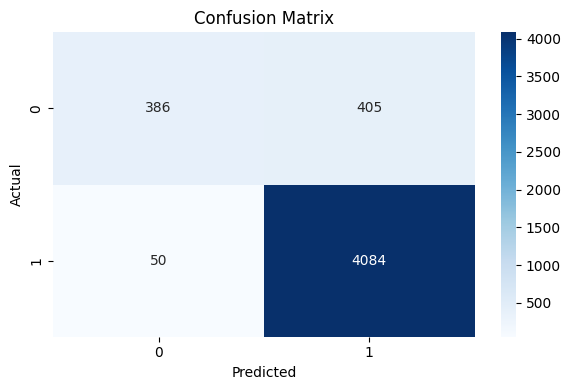


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.49      0.63       791
           1       0.91      0.99      0.95      4134

    accuracy                           0.91      4925
   macro avg       0.90      0.74      0.79      4925
weighted avg       0.91      0.91      0.90      4925



In [31]:
# Predict on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve (for binary classification)
if len(set(y_test)) == 2 and y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc = roc_auc_score(y_test, y_proba[:, 1])

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Export Preprocessor and Model 

In [32]:
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", best_model)
])

final_model.fit(X_train, y_train["ms"].ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Ordinal_Encoder',
                                                  OrdinalEncoder(),
                                                  ['religiosity', 'safety',
                                                   'love', 'globe']),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  ['age',
                                                   'num_brought_up_children'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fe840537390>)])

In [33]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)